In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
from enum import Enum

In [3]:
class Point:
    def __init__(self):
        self.x = None
        self.y = None
        self.z = None

        self.id = None


In [4]:
class CLASSIFIED_STATUS(Enum):
    SUCCESS = 0
    UNCLASSIFIED = -1
    NOISE = -2
    FAILURE = -3

#class CLASSIFIED_STATUS:
#    def __init__(self):
#        self.SUCCESS = 0
#        self.UNCLASSIFIED = -1
#        self.NOISE = -2
#        self.FAILURE = -3

class POINT_STATUS(Enum):
    CORE_POINT      = 1
    BORDER_POINT    = 2
    OTHER           = 0


In [5]:
class DBSCAN:
    def __init__(self, points, min_points_th, max_points_th, eps):
        self.__min_points_th    = min_points_th
        self.__epsiron          = eps
        self.__points           = points
        self.__points_size      = len(points)

        self.__max_points_th    = max_points_th

        self.__cluster_size     = None

        
    
    def Run(self):
        cluster_id = 1

        for point in self.__points:
            if point.cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                or point.cluster_id == CLASSIFIED_STATUS.NOISE:
                if self.ExpandCluster(point, cluster_id) != CLASSIFIED_STATUS.FAILURE:
                    cluster_id = cluster_id + 1
                else:
                    point.cluster_id = CLASSIFIED_STATUS.NOISE
        self.__cluster_size = cluster_id
        return(cluster_id)

    def CalcurateCluster(self, point):
        #print("Range Search Root:[", point.x, ",", point.y, ",", point.z, "]")
        cluster_index = []
        index = 0
        for p in self.__points:
            dist = self.CalcurateDistance(point, p)
            if dist <= self.__epsiron and self.CheckSamePoint(point, p) == False:
                if p.cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                    or p.cluster_id == CLASSIFIED_STATUS.NOISE \
                        or p.cluster_id == point.cluster_id:
                    cluster_index.append(index)
                    #print("Append ", index,":[", p.x, ",", p.y, ",", p.z,"] to current searching point list:Num:", len(cluster_index))
                #else:
                #    print("already in cluster. current cluster_id:", point.cluster_id, " candidate: ", index, "[", p.x,",", p.y, ",", p.z, "] --> ", p.cluster_id)
            #else:
            #    print("Dist:",dist, " point:[",p.x,",",p.y,"]")
                
                # Max Cluster Size
                #if len(cluster_index) >= self.__max_points_th:
                #    break
            
            index = index + 1
            
        return(cluster_index)

    def ExpandCluster(self, point, cluster_id):
        #print("-----------------------------")
        #print("Expand Cluster Start with point:[", point.x, ",", point.y, "]")
        cluster_member = []
        point.cluster_id = cluster_id
        seeds = self.CalcurateCluster(point)
        #print(seeds, "-->")

        if len(seeds) < self.__min_points_th:
            #print("No Seeds Failure\n")
            point.cluster_id = CLASSIFIED_STATUS.NOISE
            return(CLASSIFIED_STATUS.FAILURE)

        index = 0
        index_core_point = 0

        #for seed in seeds:
        #    self.__points[seed].cluster_id = cluster_id
        #    if self.CheckSamePoint(self.__points[seed], point) == True:
        #        index_core_point = index
        #        #print("Core point:", index_core_point, " list size:", len(seeds))
        #    index = index + 1

        #if index_core_point != (len(seeds)-1):
        #    seeds[index_core_point] = seeds.pop(-1)

        #for i in range(len(seeds)):
        for seed in seeds:
            # Range Search
            #cluster_member.append(seeds[i])
            #cluster_neighbors = self.CalcurateCluster(self.__points[seeds[i]])
            #print(seed, ":[", self.__points[seed].x, ",", self.__points[seed].y, "]")
            if len(cluster_member) > self.__max_points_th:
                break

            if self.__points[seed].cluster_id != cluster_id:
                self.__points[seed].cluster_id = cluster_id
                cluster_member.append(seed)
                cluster_neighbors = self.CalcurateCluster(self.__points[seed])

                if len(cluster_neighbors) >= self.__min_points_th:
                    for neighbor in cluster_neighbors:            
                        if self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                            or self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.NOISE :
                            #if self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED:
                            seeds.append(neighbor)
                            #print("Seed Added : ", neighbor)
                            #self.__points[neighbor].cluster_id = cluster_id
        
        if len(cluster_member)+1 < self.__min_points_th:
            #print("Cluster Num too small Failure : ", len(cluster_member))
            point.cluster_id = CLASSIFIED_STATUS.NOISE
            for id in cluster_member:
                self.__points[id].cluster_id = CLASSIFIED_STATUS.NOISE
            return(CLASSIFIED_STATUS.FAILURE)
        

        #print("Success", seeds,"\n")
        #print("-----------------------------\n")
        return(CLASSIFIED_STATUS.SUCCESS)
        

    def Calcurate2DDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        #dz = point_target.z - point_core.z

        distance = np.sqrt(dx ** 2 + dy ** 2)
        return(distance)


    def CalcurateDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        distance = np.sqrt(dx*dx + dy*dy + dz * dz)
        return(distance)

    def CheckSamePoint(self, point1, point2):
        distance = self.CalcurateDistance(point1, point2)
        if distance < 0.01:
            return(True)
        else:
            return(False)

    def CalcurateDoubleDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        double_distance = dx ** 2 + dy ** 2 + dz ** 2
        return(double_distance)

    def GetTotalPointSize(self):
        return(self.__point_size)

    def GetMinimumClusterSize(self):
        return(self.__min_points_th)
    
    def GetEpsilon(self):
        return(self.__epsiron)

    def GetPoints(self):
        return(self.__points)

    def GetClusterSize(self):
        return(self.__cluster_size)



In [6]:
import random


In [7]:
min_points_th = 2
max_points_th = 30
eps = 3
points_num = 1000

max_x = 50.0
max_y = 50.0

In [8]:
points = [Point() for i in range(points_num)]
for i in range(len(points)):
    points[i].x = random.uniform(0,max_x)
    points[i].y = random.uniform(0,max_y)
    points[i].z = 0
    points[i].cluster_id = CLASSIFIED_STATUS.UNCLASSIFIED

In [9]:
for i in range(len(points)):
    points[i].cluster_id = CLASSIFIED_STATUS.UNCLASSIFIED

In [10]:
db = DBSCAN( points, min_points_th, max_points_th, eps)

In [11]:
db.Run()

41

In [12]:
points = db.GetPoints()

In [13]:
#for p in points:
#    print("(", p.x, ",\t", p.y, ",\t", p.z, ") : \t", p.cluster_id)

In [14]:
import matplotlib.cm as cm
import matplotlib.patches as patches

41


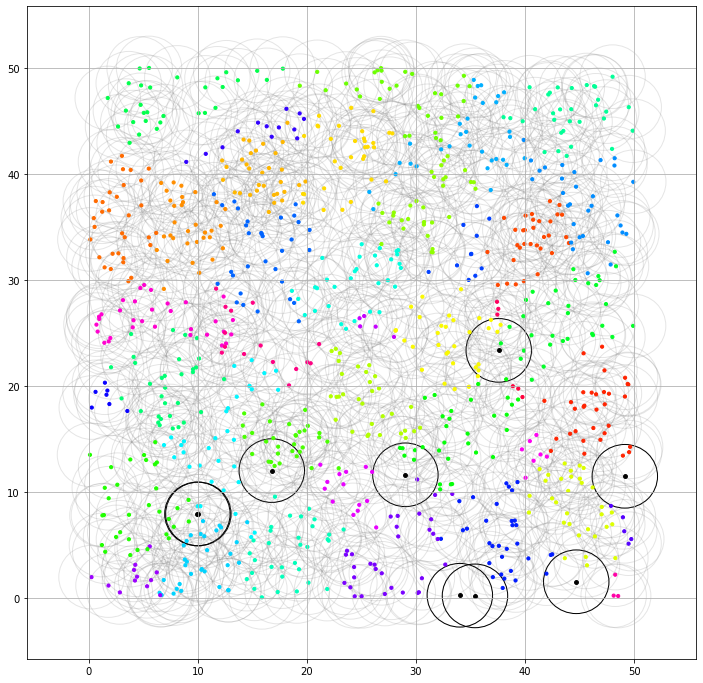

In [15]:

fig, ax = plt.subplots(figsize=[12,12])
x = []
y = []
cluster = []

noise_x = []
noise_y = []
cluster_size = db.GetClusterSize()
for p in points:
    search_circ = patches.Circle(xy=(p.x,p.y), radius=eps, ec = "gray", alpha=0.2, fc="None")
    ax.add_patch(search_circ)
    if p.cluster_id != CLASSIFIED_STATUS.NOISE:
        x.append(p.x)
        y.append(p.y)
        cluster.append(p.cluster_id / cluster_size)
    else:
        noise_x.append(p.x)
        noise_y.append(p.y)
        c = patches.Circle(xy=(p.x,p.y), radius=eps, fc="None", ec="black")
        ax.add_patch(c)
        #p.cluster_id = -2
print(cluster_size)

ax.scatter(x=x, y=y, color = cm.hsv(cluster), s = 10)
ax.scatter(x=noise_x, y=noise_y, color="black", s= 15)
ax.grid()

In [16]:
def SavePoints(filedir, points, partition = ","):
    with open(filedir, "w") as f:
        f.write(str(len(points))+"\n")
        for point in points:
            cluster_id = 0
            if point.cluster_id != CLASSIFIED_STATUS.NOISE:
                cluster_id = point.cluster_id
            else:
                cluster_id = -2
            str_data = str(point.x) + partition + str(point.y) + partition + str(point.z) + partition + str(cluster_id) + "\n"
            f.write(str_data)

In [17]:
SavePoints("./sample_pcl.xyz", points, partition=" ")